In [1]:
# Enze Xu
# Github: https://github.com/EnzeXu/PINN
# git clone https://github.com/EnzeXu/PINN.git

import torch
import time
import random
import argparse
import math
import os
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from scipy import stats
from tqdm import tqdm
from collections import OrderedDict
from torchsummary import summary
from torch.backends import cudnn
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
from torch.utils.tensorboard import SummaryWriter

from google.colab import drive
import sys
drive.mount("/content/drive")

main_path = '/content/drive/My Drive/Workspace/PINN/' # ENZE marked: you need to change your main_path if it's not here
sys.path.append(main_path)
from cyclic_lr_scheduler import CyclicLR
from utils import draw_two_dimension, draw_two_dimension_different_x

Mounted at /content/drive


In [19]:
class ConfigTuring:
    def __init__(self):
        self.T = 300.0
        self.T_unit = 1
        self.T_N = int(self.T / self.T_unit)

        self.NN = 20  # can be modified if too slow (20 / 50 / ...)
        self.MM = 1  # must be 1 (fixed)

        self.alpha = 1
        self.beta = 0.3
        self.gamma = 0.3
        self.b = 0.5
        self.c = 0.6
        self.m = 0.6
        self.q = 0.35
        self.d1 = 0.015
        self.d2 = 1

        self.s = 3.0  # 1.75, 1.9, 2.0, 2.45, 3.0

        self.l = 1
        self.w = 1

        np.random.seed(0)

        self.u_0 = np.random.rand(self.NN, self.MM).reshape([self.NN * self.MM])
        self.v_0 = np.random.rand(self.NN, self.MM).reshape([self.NN * self.MM])
        self.y_0 = np.concatenate([self.u_0, self.v_0])

        self.ub = self.T
        self.lb = 0.0

        self.only_truth_flag = False  # True means only using loss_1 for truth_rate = 1.00, no other loss
        self.truth_rate = 0.0034 #0.0034 # 0.0034 * 300 = 1 point(s) as truth #1.00 #0.25 #0.0005
        self.truth_length = int(self.truth_rate * self.T / self.T_unit)
        if not self.only_truth_flag:
            print("self.truth_length: {} of {} all ".format(self.truth_length, self.T_N))


def block_design_a(network_unit, sig):
    return nn.Sequential((OrderedDict({
      'lin1': nn.Linear(1, network_unit),
      'sig1': sig,
      'lin2': nn.Linear(network_unit, network_unit),
      'sig2': sig,
      'lin3': nn.Linear(network_unit, network_unit),
      'sig3': sig,
      'lin4': nn.Linear(network_unit, 1),
    })))

class SimpleNetworkTuring(nn.Module):
    def __init__(self, config):
        super(SimpleNetworkTuring, self).__init__()
        self.setup_seed(0)
        self.config = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.x, self.y0, self.t0 = None, None, None
        self.generate_x()
        # self.optimizer = optim.LBFGS(self.parameters(), lr=0.001, max_iter=5000, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100, line_search_fn=None)
        self.initial_start()
        self.model_name = "SimpleNetworkTuring"
        self.gt = GroundTruthTuring(self.config.T, self.config.T_N)
        self.gt_u = torch.Tensor(self.gt.u).to(self.device)
        self.gt_v = torch.Tensor(self.gt.v).to(self.device)

        self.sig = nn.Tanh()
        self.network_unit = 100
        self.sequences_u = []
        self.sequences_v = []

        # Design A

        u_blocks = [block_design_a(self.network_unit, self.sig) for i in range(self.config.NN)]
        v_blocks = [block_design_a(self.network_unit, self.sig) for i in range(self.config.NN)]

        self.sequences_u = nn.Sequential(*u_blocks)
        self.sequences_v = nn.Sequential(*v_blocks)

        # self.sequences_u1 = nn.Sequential(OrderedDict({
        #   'lin1': nn.Linear(1, self.network_unit),
        #   'sig1': self.sig,
        #   'lin2': nn.Linear(self.network_unit, self.network_unit),
        #   'sig2': self.sig,
        #   'lin3': nn.Linear(self.network_unit, self.network_unit),
        #   'sig3': self.sig,
        #   'lin4': nn.Linear(self.network_unit, 1),
        # }))
        # self.sequences_u2 = nn.Sequential(OrderedDict({
        #   'lin1': nn.Linear(1, self.network_unit),
        #   'sig1': self.sig,
        #   'lin2': nn.Linear(self.network_unit, self.network_unit),
        #   'sig2': self.sig,
        #   'lin3': nn.Linear(self.network_unit, self.network_unit),
        #   'sig3': self.sig,
        #   'lin4': nn.Linear(self.network_unit, 1),
        # }))
        # self.sequences_v1 = nn.Sequential(OrderedDict({
        #   'lin1': nn.Linear(1, self.network_unit),
        #   'sig1': self.sig,
        #   'lin2': nn.Linear(self.network_unit, self.network_unit),
        #   'sig2': self.sig,
        #   'lin3': nn.Linear(self.network_unit, self.network_unit),
        #   'sig3': self.sig,
        #   'lin4': nn.Linear(self.network_unit, 1),
        # }))
        # self.sequences_v2 = nn.Sequential(OrderedDict({
        #   'lin1': nn.Linear(1, self.network_unit),
        #   'sig1': self.sig,
        #   'lin2': nn.Linear(self.network_unit, self.network_unit),
        #   'sig2': self.sig,
        #   'lin3': nn.Linear(self.network_unit, self.network_unit),
        #   'sig3': self.sig,
        #   'lin4': nn.Linear(self.network_unit, 1),
        # }))

        # self.encoder = nn.Sequential(*conv_blocks)
        # for i in range(self.config.NN):
        #   self.sequences_u.append(nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, self.network_unit),
        #     'sig1': self.sig,
        #     'lin2': nn.Linear(self.network_unit, self.network_unit),
        #     'sig2': self.sig,
        #     'lin3': nn.Linear(self.network_unit, self.network_unit),
        #     'sig3': self.sig,
        #     'lin4': nn.Linear(self.network_unit, 1),
        #   })))
        #   self.sequences_v.append(nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, self.network_unit),
        #     'sig1': self.sig,
        #     'lin2': nn.Linear(self.network_unit, self.network_unit),
        #     'sig2': self.sig,
        #     'lin3': nn.Linear(self.network_unit, self.network_unit),
        #     'sig3': self.sig,
        #     'lin4': nn.Linear(self.network_unit, 1),
        #   })))


    def forward(self, inputs):
        # print(inputs.shape)
        # print("inputs=", inputs)
        # print("forward inputs shape:", inputs.shape)
        u_input, v_input = inputs[:, :self.config.NN * self.config.MM], inputs[:, self.config.NN * self.config.MM:]
        # print("u_input shape:", u_input.shape, u_input)
        # print("v_input shape:", v_input.shape, v_input)
        u_output, v_output = [], []
        
        # Design A
        
        for i in range(self.config.NN):
          u_output.append(self.sequences_u[i](u_input[:,i:i+1]))
          v_output.append(self.sequences_v[i](v_input[:,i:i+1]))
        
        # u_output.append(self.sequences_u1(u_input[:,0:0+1]))
        # u_output.append(self.sequences_u2(u_input[:,1:1+1]))
        # v_output.append(self.sequences_v1(v_input[:,0:0+1]))
        # v_output.append(self.sequences_v2(v_input[:,1:1+1]))

        u_output = torch.cat(tuple(item for item in u_output), 1)
        v_output = torch.cat(tuple(item for item in v_output), 1)

        outputs = torch.cat((u_output, v_output), 1)
        # print("forward outputs shape:",outputs.shape)
        return outputs

    def generate_x(self):
        x = [[i*self.config.T_unit] * (self.config.NN * 2) for i in range(self.config.T_N)]
        # print(x)
        x = np.asarray(x)
        x = self.encode_t(x)
        self.x = torch.Tensor(x).float().to(self.device)
        # print("self.x shape:", self.x.shape)

    def initial_start(self):
        self.t0 = torch.Tensor(np.asarray([-1.0] * (2 * self.config.NN)).reshape([1, -1])).float().to(self.device)
        self.y0 = torch.Tensor(self.config.y_0.reshape([1, -1])).float().to(self.device)
    
    def loss_only_ground_truth(self):
        self.eval()
        y = self.forward(self.x)
        u = y[:, :self.config.NN * self.config.MM]
        v = y[:, self.config.NN * self.config.MM:]
        self.loss_norm = torch.nn.MSELoss().to(self.device)
        # print(y.shape, self.gt_data.shape)
        loss = self.loss_norm(u, self.gt_u) + self.loss_norm(v, self.gt_v)
        self.train()
        return loss, [loss]
    
    def loss(self):
        self.eval()
        y = self.forward(self.x)
        # print("y shape:", y.shape)

        u = y[:, :self.config.NN * self.config.MM]
        v = y[:, self.config.NN * self.config.MM:]

        u_t_collection, v_t_collection = [], []
        for ii in range(self.config.NN):
          u_t_collection.append(torch.gradient(u[:,ii:ii+1].reshape([self.config.T_N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.T_N]),))[0].reshape([self.config.T_N,1]))
          v_t_collection.append(torch.gradient(v[:,ii:ii+1].reshape([self.config.T_N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.T_N]),))[0].reshape([self.config.T_N,1]))
        u_t = torch.cat(u_t_collection, 1)
        v_t = torch.cat(v_t_collection, 1)


        u_from_left = torch.roll(u, 1, 1)
        u_from_left[:, :1] = u[:, :1]
        u_from_right = torch.roll(u, -1, 1)
        u_from_right[:, -1:] = u[:, -1:]

        v_from_left = torch.roll(v, 1, 1)
        v_from_left[:, :1] = v[:, :1]
        v_from_right = torch.roll(v, -1, 1)
        v_from_right[:, -1:] = v[:, -1:]

        u_diffusion = self.config.d1 * ((u_from_left + u_from_right - u * 2) / (self.config.l ** 2))
        v_diffusion = self.config.d2 * ((v_from_left + v_from_right - v * 2) / (self.config.l ** 2))

        u_reaction = u * (self.config.alpha - self.config.beta * u - self.config.q / (u + self.config.b)) - self.config.c * u * v / (self.config.m * v + 1)
        v_reaction = v * (-self.config.gamma + self.config.s * u / (self.config.m * v + 1))

        u_t_target = u_diffusion + u_reaction
        v_t_target = v_diffusion + v_reaction

        f_u = u_t - u_t_target
        f_v = v_t - v_t_target
        
        f_y = torch.cat((f_u, f_v), 1)
        # print("f_y shape:", f_y.shape)
        y0_pred = self.forward(self.t0)
        
        # loss_1 = torch.mean(torch.square(self.y0 - y0_pred))
        self.loss_norm = torch.nn.MSELoss().to(self.device)
        zeros_2mn_D = torch.Tensor([[0.0] * (2 * self.config.NN * self.config.MM)] * self.config.T_N).to(self.device)

        loss_1 = self.loss_norm(u[:self.config.truth_length, :], self.gt_u[:self.config.truth_length, :]) + self.loss_norm(v[:self.config.truth_length, :], self.gt_v[:self.config.truth_length, :])

        loss_2 = self.loss_norm(f_y, zeros_2mn_D)
        loss_3 = self.loss_norm(0.001/(y * y + 1e-6), zeros_2mn_D)
        loss_4 = self.loss_norm(torch.abs(y) - y, zeros_2mn_D)


        # loss_3 = torch.mean(torch.square((torch.abs(s) - s))) + torch.mean(torch.square((torch.abs(i) - i))) + torch.mean(torch.square((torch.abs(r) - r))) #+ torch.mean(torch.square((0.1/(s * s)))) + torch.mean(torch.square((0.1/(i * i)))) + torch.mean(torch.square((0.1/(r * r))))
        # loss_4 = torch.mean(torch.square(0.00001 / ((s * s + i * i) * (i * i + r * r) * (s * s + r * r) + 1e-8)))

        # 04/27 TODO: re-design the loss functions. I want to do it but Chen asked me to implement new models. Now it's your turn.

        loss = loss_1 + loss_2 + loss_3 + loss_4
        # if loss < 2.0:
        #     f_y_square_pure = torch.square(f_y).cpu().detach().numpy()
        #     for i in range(20000):
        #         print(i, f_y_square_pure[i])
        self.train()
        return loss, [loss_1, loss_2, loss_3, loss_4]
        # return torch.mean(torch.square(y_hat - y))
        # return F.mse_loss(torch.cat((u_hat, v_hat), 1), torch.cat((u, v), 1))
        # return torch.abs(u_hat - u) + torch.abs(v_hat - v)  # F.mse_loss(x_hat, x) + beta * self.kl_div(rho)


    def encode_t(self, num):
        return (num - self.config.lb) / (self.config.ub - self.config.lb) * 2.0 - 1.0

    def decode_t(self, num):
        return self.config.lb + (num + 1.0) / 2.0 * (self.config.ub - self.config.lb)

    @staticmethod
    def setup_seed(seed):
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        cudnn.deterministic = True

In [17]:
class GroundTruthTuring:
  def __init__(self, t_max, length):
    np.random.seed(0)
    self.config = ConfigTuring()
    param_keys = ["NN", "MM", "l", "w", "alpha", "beta", "gamma", "b", "c", "m", "q", "d1", "d2", "s"]
    config_tuple = tuple(self.config.__dict__.get(one_key) for one_key in param_keys)

    u_0 = np.random.rand(self.config.NN, self.config.MM)
    v_0 = np.random.rand(self.config.NN, self.config.MM)

    y0 = np.concatenate([u_0.flatten(), v_0.flatten()])
    self.t = np.linspace(0, t_max, length)
    # print(self.t)
    sol = odeint(self.pend, y0, self.t, args=config_tuple)
    # print(sol.shape)
    self.u = sol[:, :self.config.NN * self.config.MM]
    self.u_map = self.u.swapaxes(0, 1)
    self.v = sol[:, self.config.NN * self.config.MM:]
    self.v_map = self.v.swapaxes(0, 1)
    print("truth shape: u: {}, v: {}".format(self.u.shape, self.v.shape))
  
  @staticmethod
  def get_diffusion(maps, N, M, l, w, alpha, beta, gamma, b, c, m, q, d1, d2, s):
    u_input, v_input = maps[0], maps[1]
    u_from_left = np.roll(u_input, 1, axis=1)
    u_from_left[:, :1] = u_input[:, :1]
    u_from_right = np.roll(u_input, -1, axis=1)
    u_from_right[:, -1:] = u_input[:, -1:]
    u_from_top = np.roll(u_input, 1, axis=0)
    u_from_top[:1, :] = u_input[:1, :]
    u_from_bottom = np.roll(u_input, -1, axis=0)
    u_from_bottom[-1:, :] = u_input[-1:, :]
    v_from_left = np.roll(v_input, 1, axis=1)
    v_from_left[:, :1] = v_input[:, :1]
    v_from_right = np.roll(v_input, -1, axis=1)
    v_from_right[:, -1:] = v_input[:, -1:]
    v_from_top = np.roll(v_input, 1, axis=0)
    v_from_top[:1, :] = v_input[:1, :]
    v_from_bottom = np.roll(v_input, -1, axis=0)
    v_from_bottom[-1:, :] = v_input[-1:, :]
    u_diffusion = ((u_from_left + u_from_right - u_input * 2) / (l ** 2) + (u_from_top + u_from_bottom - u_input * 2) / (w ** 2)) * d1
    v_diffusion = ((v_from_left + v_from_right - v_input * 2) / (l ** 2) + (v_from_top + v_from_bottom - v_input * 2) / (w ** 2)) * d2
    return np.asarray([u_diffusion, v_diffusion])
  
  def pend(self, y, t, N, M, l, w, alpha, beta, gamma, b, c, m, q, d1, d2, s):
    # print(N, l, w, alpha, beta, gamma, b, c, m, q, d1, d2, s)
    u, v = y[:N * M].reshape([N, M]), y[N * M:].reshape([N, M])
    maps = np.asarray([u, v])
    d_reaction = np.asarray([
                            u * (alpha - beta * u - q / (u + b)) - c * u * v / (m * v + 1),
                            v * (-gamma + s * u / (m * v + 1))])
    d_diffusion = self.get_diffusion(maps, N, M, l, w, alpha, beta, gamma, b, c, m, q, d1, d2, s)
    dydt = d_reaction + d_diffusion
    dydt = np.concatenate([dydt[0].flatten(), dydt[1].flatten()])
    return dydt

  def print(self):
    draw_turing(self.u_map, self.v_map, self.config)


def get_now_string():
    return time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime(time.time()))

def draw_turing(u, v, config, save_flag=False, save_path=None):

    fig = plt.figure(figsize=(24, 5))

    ax1 = fig.add_subplot(121)
    im1 = ax1.imshow(u, cmap=plt.cm.jet, vmin=u[:,-1:].min(), vmax=u[:,-1:].max(), aspect='auto')
    ax1.set_title("u (s={0:.2f})".format(config.s))
    cb1 = plt.colorbar(im1, shrink=1)

    ax2 = fig.add_subplot(122)
    im2 = ax2.imshow(v, cmap=plt.cm.jet, vmin=v[:,-1:].min(), vmax=v[:,-1:].max(), aspect='auto')
    ax2.set_title("v (s={0:.2f})".format(config.s))
    cb2 = plt.colorbar(im2, shrink=1)
    plt.tight_layout()
    if save_flag:
        plt.savefig(save_path, dpi=300)
    plt.show()
    plt.clf()

def train_turing(model, args, config, now_string):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = model_framework(config).to(device)
    model.train()
    model_save_path_last = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_last.pt"
    model_save_path_best = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_best.pt"
    loss_save_path = f"{args.main_path}/loss/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_loss_{args.epoch}.npy"
    print("using " + str(device))
    print("epoch = {}".format(args.epoch))
    print("epoch_step = {}".format(args.epoch_step))
    print("model_name = {}".format(model.model_name))
    print("now_string = {}".format(now_string))
    print("model_save_path_last = {}".format(model_save_path_last))
    print("model_save_path_best = {}".format(model_save_path_best))
    print("loss_save_path = {}".format(loss_save_path))
    # optimizer = optim.Adam(model.parameters(), lr=args.lr)
    initial_lr = args.lr
    optimizer = optim.Adam(model.parameters(), lr = initial_lr)
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1/(epoch/10000+1))
    # scheduler = CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, step_size=1000)
    # optimizer = optim.LBFGS(model.parameters(), lr=args.lr, max_iter=5000, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100,
    #       line_search_fn=None)

    epoch_step = args.epoch_step
    start_time = time.time()
    start_time_0 = start_time
    best_loss = np.inf
    loss_record = []
    for epoch in range(1, args.epoch + 1):
        optimizer.zero_grad()
        inputs = model.x
        outputs = model(inputs)
        # u_hat, v_hat = torch.chunk(outputs, 2, 1)
        if config.only_truth_flag:
            loss, loss_list = model.loss_only_ground_truth()
        else:
            loss, loss_list = model.loss()
        # loss_1, loss_2, loss_3 = loss_list[0], loss_list[1], loss_list[2]
        loss.backward()
        optimizer.step()
        scheduler.step()
        loss_record.append(float(loss.item()))
        if epoch % epoch_step == 0:
            now_time = time.time()
            loss_print_part = " ".join(["Loss_{0:d}:{1:.6f}".format(i + 1, loss_part.item()) for i, loss_part in enumerate(loss_list)])
            # print("Epoch [{0:05d}/{1:05d}] Loss:{2:.6f} Loss_1:{3:.6f} Loss_2:{4:.6f} Loss_3: {5:.6f} Lr:{6:.6f} Time:{7:.6f}s ({8:.2f}min in total)".format(epoch, args.epoch, loss.item(), loss_1.item(), loss_2.item(), loss_3.item(), optimizer.param_groups[0]["lr"], now_time - start_time, (now_time - start_time_0) / 60.0))
            print("Epoch [{0:05d}/{1:05d}] Loss:{2:.6f} {3} Lr:{4:.6f} Time:{5:.6f}s ({6:.2f}min in total, {7:.2f}min remains)".format(epoch, args.epoch, loss.item(), loss_print_part, optimizer.param_groups[0]["lr"], now_time - start_time, (now_time - start_time_0) / 60.0, (now_time - start_time_0) / 60.0 / epoch * (args.epoch - epoch)))
            start_time = time.time()
            torch.save(
                {
                    'epoch': args.epoch,
                    'model_state_dict': model.state_dict(),
                    # 'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item()
                }, model_save_path_last)
            # print(inputs.shape)
            if loss.item() < best_loss:
                best_loss = loss.item()
                torch.save(
                    {
                        'epoch': args.epoch,
                        'model_state_dict': model.state_dict(),
                        # 'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss.item()
                    }, model_save_path_best)
        if epoch % args.save_step == 0:
            test_turing(model, args, config, now_string, True)
            draw_loss(np.asarray(loss_record))
            np.save(loss_save_path, np.asarray(loss_record))

def test_turing(model, args, config, now_string, show_flag=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = model_framework(config).to(device)
    model_save_path = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_last.pt"
    # model.load_state_dict(torch.load(model_save_path, map_location=device)["model_state_dict"])
    model.eval()
    print("Testing & drawing...")
    t = model.x
    y = model(t)
    y0_pred = model(model.t0)
    u, v = y[:, :model.config.NN * model.config.MM], y[:, model.config.NN * model.config.MM:]
    u = u.cpu().detach().numpy().swapaxes(0, 1)
    v = v.cpu().detach().numpy().swapaxes(0, 1)
    figure_save_path = f"{args.main_path}/figure/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_{int(time.time())}.png"
    print("Truth:")
    draw_turing(model.gt.u_map, model.gt.v_map, model.config, False, None)
    print("Pred:")
    draw_turing(u, v, model.config, True, figure_save_path)
    print("Diff:")
    draw_turing(model.gt.u_map - u, model.gt.v_map - v, model.config, False, None)


class Args:
  epoch = 100000
  epoch_step = 100
  lr = 0.001
  main_path = "."
  save_step = 1000

def draw_loss(loss_list):
    draw_two_dimension(
        y_lists=[loss_list],
        x_list=range(1, len(loss_list) + 1),
        color_list=["blue"],
        legend_list=["loss"],
        line_style_list=["solid"],
        fig_title="Loss - {} epochs".format(len(loss_list)),
        fig_x_label="epoch",
        fig_y_label="loss",
        fig_size=(8, 6),
        show_flag=True,
        save_flag=False,
        save_path=None
    )

def run_turing(main_path=None):
    # parser = argparse.ArgumentParser()
    # parser.add_argument("--epoch", type=int, default=1000, help="epoch")
    # parser.add_argument("--epoch_step", type=int, default=10, help="epoch_step")
    # parser.add_argument('--lr', type=float, default=0.01, help='learning rate, default=0.001')
    # parser.add_argument("--main_path", default=".", help="main_path")
    # parser.add_argument("--save_step", type=int, default=100, help="save_step")
    # args = parser.parse_args()
    args = Args
    if main_path:
        args.main_path = main_path
    if not os.path.exists("{}/train".format(args.main_path)):
        os.makedirs("{}/train".format(args.main_path))
    if not os.path.exists("{}/figure".format(args.main_path)):
        os.makedirs("{}/figure".format(args.main_path))
    now_string = get_now_string()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    config = ConfigTuring()
    model = SimpleNetworkTuring(config).to(device)
    train_turing(model, args, config, now_string)
    # model = SimpleNetworkTuring(config).to(device)
    # test_turing(model, args, config, now_string)

In [ ]:
# Turing - normal - redesign the loss part(s) and start here!
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
run_turing(main_path)

In [18]:
# Turing - normal - only truth - 20 * 300
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
run_turing(main_path)

Output hidden; open in https://colab.research.google.com to view.

In [79]:
# Turing - normal - 1.00 truth (300 point) - 2 * 300
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
run_turing(main_path)

Output hidden; open in https://colab.research.google.com to view.

In [72]:
# Turing - normal - 0.0034 truth (1 point) - 2 * 300
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
run_turing(main_path)

Output hidden; open in https://colab.research.google.com to view.

self.truth_length: 300 of 300 all 
[[0, 0, 0, 0], [1, 1, 1, 1], [2, 2, 2, 2], [3, 3, 3, 3], [4, 4, 4, 4], [5, 5, 5, 5], [6, 6, 6, 6], [7, 7, 7, 7], [8, 8, 8, 8], [9, 9, 9, 9], [10, 10, 10, 10], [11, 11, 11, 11], [12, 12, 12, 12], [13, 13, 13, 13], [14, 14, 14, 14], [15, 15, 15, 15], [16, 16, 16, 16], [17, 17, 17, 17], [18, 18, 18, 18], [19, 19, 19, 19], [20, 20, 20, 20], [21, 21, 21, 21], [22, 22, 22, 22], [23, 23, 23, 23], [24, 24, 24, 24], [25, 25, 25, 25], [26, 26, 26, 26], [27, 27, 27, 27], [28, 28, 28, 28], [29, 29, 29, 29], [30, 30, 30, 30], [31, 31, 31, 31], [32, 32, 32, 32], [33, 33, 33, 33], [34, 34, 34, 34], [35, 35, 35, 35], [36, 36, 36, 36], [37, 37, 37, 37], [38, 38, 38, 38], [39, 39, 39, 39], [40, 40, 40, 40], [41, 41, 41, 41], [42, 42, 42, 42], [43, 43, 43, 43], [44, 44, 44, 44], [45, 45, 45, 45], [46, 46, 46, 46], [47, 47, 47, 47], [48, 48, 48, 48], [49, 49, 49, 49], [50, 50, 50, 50], [51, 51, 51, 51], [52, 52, 52, 52], [53, 53, 53, 53], [54, 54, 54, 54], [55, 55, 55, 5

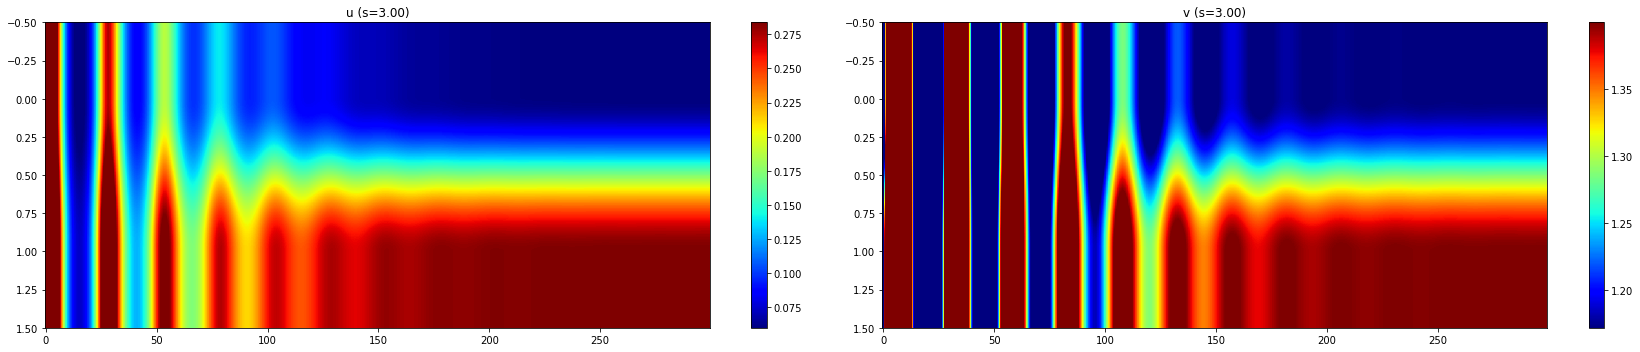

Pred:


<Figure size 432x288 with 0 Axes>

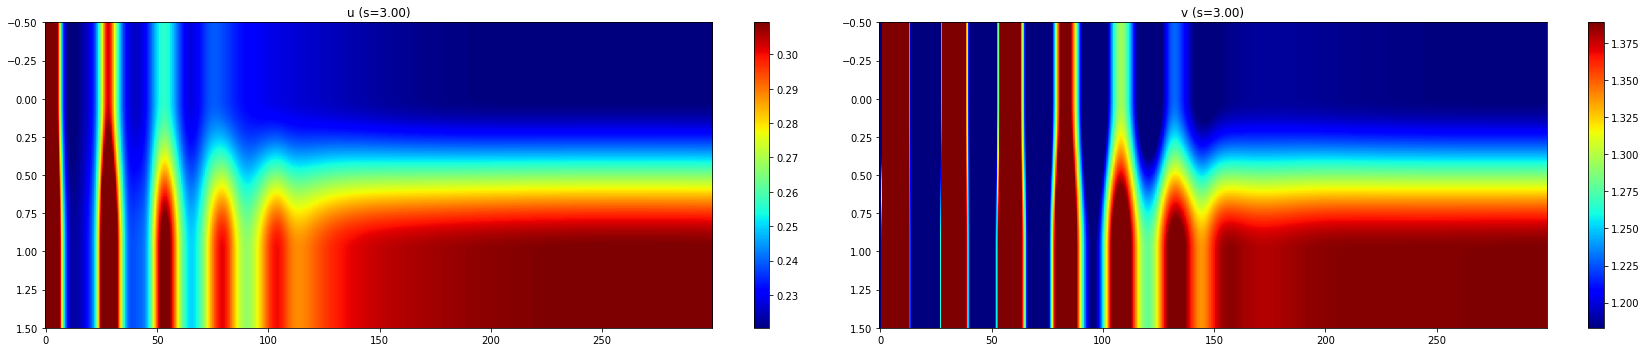

Diff:


<Figure size 432x288 with 0 Axes>

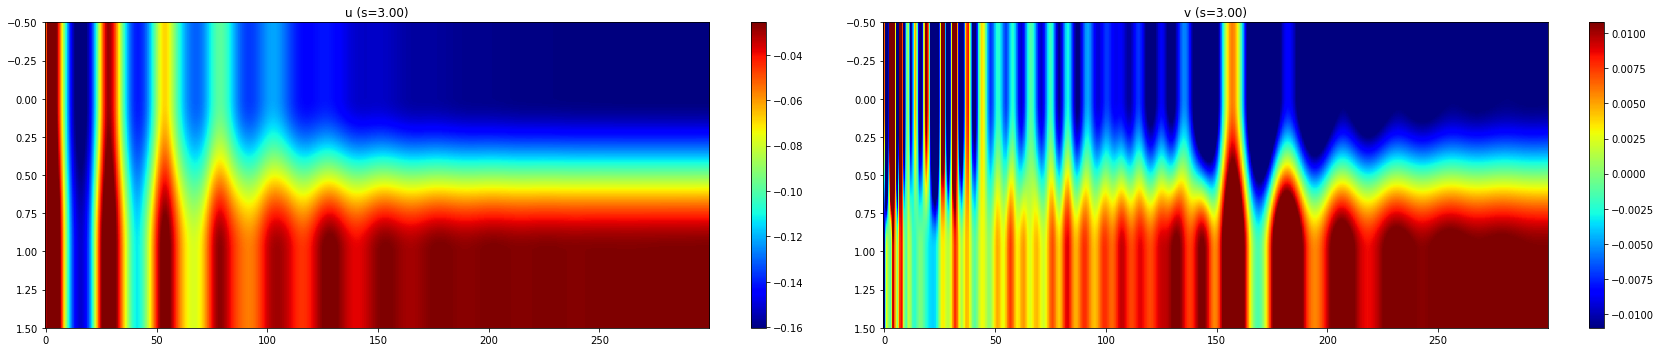

<Figure size 432x288 with 0 Axes>

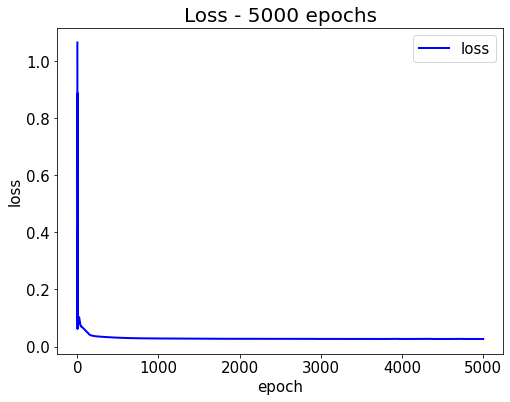

Epoch [06000/100000] Loss:0.026434 Loss_1:0.011296 Loss_2:0.022168 Loss_3:0.012921 Loss_4:0.000000 Lr:0.000625 Time:15.634787s (1.24min in total, 19.50min remains)


KeyboardInterrupt: ignored

In [77]:
# debug here

args = Args
args.main_path = "/content/drive/My Drive/Workspace/PINN"
model_save_path = "/content/drive/My Drive/Workspace/PINN/train/SimpleNetworkTuring_10000_100_0.01_2022-06-07-08-10-46_last.pt" # SimpleNetworkTuring_10000_100_0.01_2022-06-07-08-10-46_last
now_string = get_now_string()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = ConfigTuring()
model = SimpleNetworkTuring(config).to(device)
model.load_state_dict(torch.load(model_save_path, map_location=device)["model_state_dict"])
print("config = {}".format({item[0]: item[1] for item in model.config.__dict__.items() if item[0][0] != "_"}))
# test_turing(model, args, config, now_string, True)
loss, loss_list = model.loss()
print("loss:", loss)
print("loss_list:", loss_list)
train_turing(model, args, config, now_string)
# model.eval()

# y = model.forward(model.x)
# u = y[:, :2]
# v = y[:, 2:]

# u_gt = model.gt_u
# v_gt = model.gt_v

# # print("u_gt - u:", u_gt - u)
# # print("v_gt - v:", v_gt - v)

# u_t_collection, v_t_collection = [], []
# for ii in range(model.config.NN):
#   u_t_collection.append(torch.gradient(u[:,ii:ii+1].reshape([model.config.T_N]), spacing=(model.decode_t(model.x)[:, 0:1].reshape([model.config.T_N]),))[0].reshape([model.config.T_N,1]))
#   v_t_collection.append(torch.gradient(v[:,ii:ii+1].reshape([model.config.T_N]), spacing=(model.decode_t(model.x)[:, 0:1].reshape([model.config.T_N]),))[0].reshape([model.config.T_N,1]))
# u_t = torch.cat(u_t_collection, 1)
# v_t = torch.cat(v_t_collection, 1)

# u_from_left = torch.roll(u, 1, 1)
# u_from_left[:, :1] = u[:, :1]
# u_from_right = torch.roll(u, -1, 1)
# u_from_right[:, -1:] = u[:, -1:]

# v_from_left = torch.roll(v, 1, 1)
# v_from_left[:, :1] = v[:, :1]
# v_from_right = torch.roll(v, -1, 1)
# v_from_right[:, -1:] = v[:, -1:]

# u_diffusion = model.config.d1 * ((u_from_left + u_from_right - u * 2) / (model.config.l ** 2))
# v_diffusion = model.config.d2 * ((v_from_left + v_from_right - v * 2) / (model.config.l ** 2))

# u_reaction = u * (model.config.alpha - model.config.beta * u - model.config.q / (u + model.config.b)) - model.config.c * u * v / (model.config.m * v + 1)
# v_reaction = v * (-model.config.gamma + model.config.s * u / (model.config.m * v + 1))

# u_t_target = u_diffusion + u_reaction
# v_t_target = v_diffusion + v_reaction

# print("u_t:", u_t)
# print("u_t_target:", u_t_target)

# print("v_t:", v_t)
# print("v_t_target:", v_t_target)

# f_u = u_t - u_t_target
# f_v = v_t - v_t_target

# print("f_u:", f_u)
# print("f_v:", f_v)




In [ ]:
# Turing - only truth 20 * 300
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
run_turing(main_path)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Turing - only truth 20 * 300
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
run_turing(main_path)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Turing - only truth 100 * 300
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
run_turing(main_path)

Output hidden; open in https://colab.research.google.com to view.